In [1]:
# #檢查tensorflow GPU
# import tensorflow as tf
# # 判断CUDA是否可以用
# a = tf.test.is_built_with_cuda() 
# # 判断GPU是否可以用
# b = tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None) 
# print(a)
# print(b)
# print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
output = pd.read_csv('output.csv')

## 從推薦系統(Recommender System,RS)的角度進行分群
### 以Collaborative Filtering(協同過濾,CF)定義user-user相似性

In [3]:
#從六大類商品建構user-item matrix
pivot_table = output[['Wines','Fruits','Meat','Fish','Sweets','Gold']]
#建構user-user CF
pivot_table_user = pivot_table.T
corr_table = pivot_table_user.corr()

In [4]:
#使用networkX套件進行網路分析及作圖
import networkx as nx
import community
from community import community_louvain
%matplotlib inline

start = np.array([])
end = np.array([])
weight = np.array([])
for i in corr_table.columns:
    start = np.append(start,
    np.array([i]*len(corr_table[i].index))[i+1:]
    )
    end = np.append(end,
    np.array(corr_table[i].index)[i+1:]
    )
    weight = np.append(weight,
    np.array(corr_table[i].values)[i+1:]
    )
#完成user-user相似性dataframe
graph_df = pd.DataFrame({'start':start,'end':end,'weight':weight})

藉由得到user-user CF,可以建置graph  
以圖論角度進行分群

In [6]:
#為weight取一個threshold,縮小graph內容
graph_df_filtered = graph_df[graph_df['weight']>0.5]
print('未取threshold,原始資料量為:',graph_df.shape[0])
print('取threshold=0.5,資料量為:',graph_df_filtered.shape[0])

未取threshold,原始資料量為: 2498730
取threshold=0.5,資料量為: 633730


In [37]:
#以user-user相似性繪製graph
G = nx.from_pandas_edgelist(graph_df_filtered, 'start', 'end',edge_attr='weight')

使用Louvain演算法分群  
https://smiliu.xyz/posts/39382  
● Louvain 演算法每次分群結果都有差異,可能為graph的edge太多,或是演算法本身就不會的到固定的結果

community:  4.0


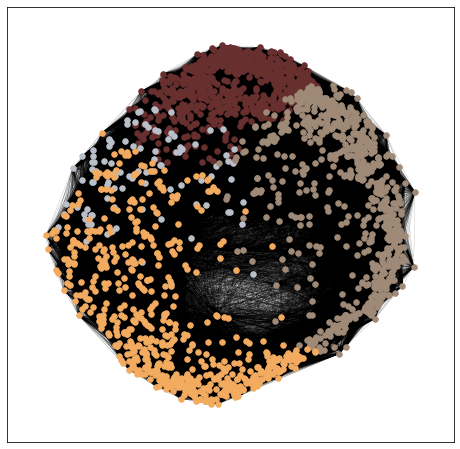

In [38]:
partition = community_louvain.best_partition(G, resolution = 1)

# #Louvain 演算法分群 Drawing(原code)
# size = float(len(set(partition.values())))  # community 群組
# pos = nx.spring_layout(G)  # nodes 的 xy軸
# cm = plt.cm.get_cmap('RdYlBu', size)
# count = 0.
# print('community: ', size)
# plt.figure(1, figsize=(8,8))
# for com in set(partition.values()) :
#     count += 1.
#     color_code = '#%02x%02x%02x' % (cm(count/size, bytes=True)[:3])  # RGB to color code
#     list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
#     nx.draw_networkx_nodes(G, pos, list_nodes, node_size=30, node_color=color_code)
#     nx.draw_networkx_labels(G, pos, font_size=10)

# nx.draw_networkx_edges(G, pos, width=0.1, alpha=1)
# plt.show()

#Louvain 演算法分群 Drawing
size = float(len(set(partition.values())))  # community 群組
pos = nx.spring_layout(G)  # nodes 的 xy軸
cm = plt.cm.get_cmap('RdYlBu', size)
count = 0.
color_code = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]

print('community: ', size)
plt.figure(1, figsize=(8,8))
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=30, node_color=color_code[com])
    #nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=1)
plt.show()

In [39]:
#將分群結果合併回原dataframe進行群組比較
output['graph_clusters'] = output.index.map(lambda x:partition.get(x, None))

graph_clusters
0    809
1    100
2    703
3    624
Name: clusters, dtype: int64


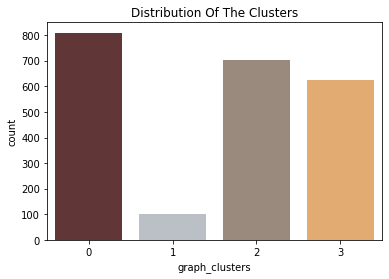

In [41]:
#檢查分群情況
print(output.groupby('graph_clusters')['clusters'].count())
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=output["graph_clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [42]:
#兩種分群方法比較
pd.pivot_table(output,values='Response',index=['clusters'],columns=['graph_clusters'],aggfunc='count')

graph_clusters,0,1,2,3
clusters,,,,
0,204,3,145,67
1,175,56,165,240
2,283,4,174,21
3,147,37,219,296


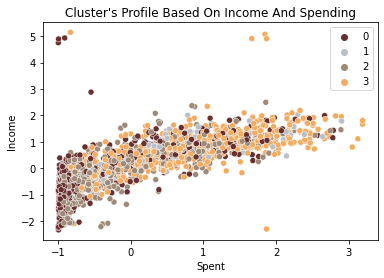

In [43]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.scatterplot(data = output,x=output["Spent"], y=output["Income"],hue=output["graph_clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

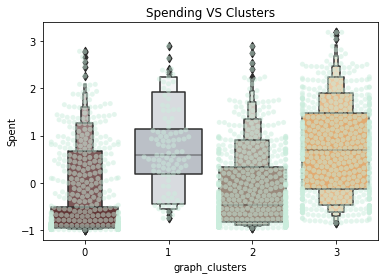

In [44]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Spent"], palette=pal)
pl.set_title("Spending VS Clusters")
plt.show()

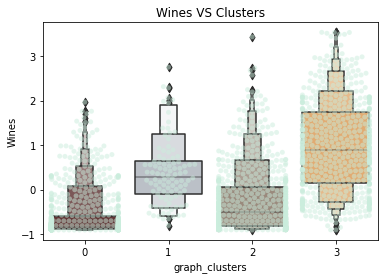

In [45]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Wines"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Wines"], palette=pal)
pl.set_title("Wines VS Clusters")
plt.show()

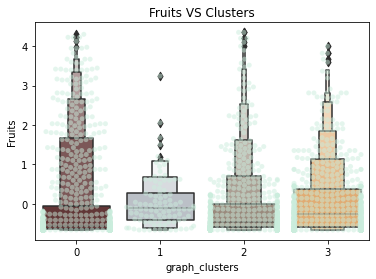

In [46]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Fruits"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Fruits"], palette=pal)
pl.set_title("Fruits VS Clusters")
plt.show()

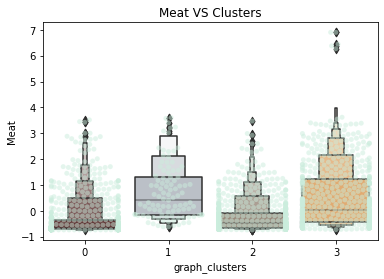

In [47]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Meat"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Meat"], palette=pal)
pl.set_title("Meat VS Clusters")
plt.show()

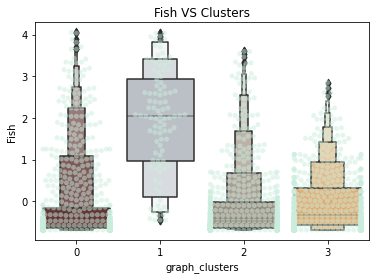

In [49]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Fish"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Fish"], palette=pal)
pl.set_title("Fish VS Clusters")
plt.show()

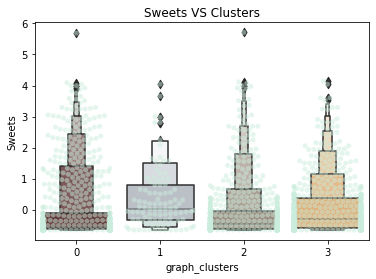

In [50]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Sweets"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Sweets"], palette=pal)
pl.set_title("Sweets VS Clusters")
plt.show()

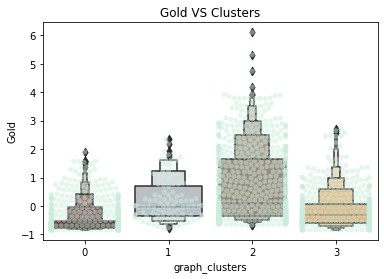

In [51]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Gold"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Gold"], palette=pal)
pl.set_title("Gold VS Clusters")
plt.show()

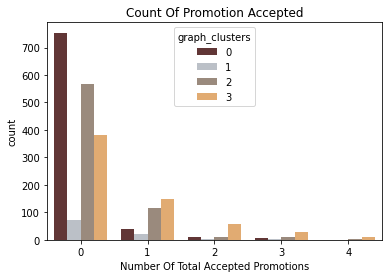

In [52]:
#Plotting count of total campaign accepted.
output["Total_Promos"] = output["AcceptedCmp1"]+ output["AcceptedCmp2"]+ output["AcceptedCmp3"]+ output["AcceptedCmp4"]+ output["AcceptedCmp5"]
plt.figure()
pl = sns.countplot(x=output["Total_Promos"],hue=output["graph_clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

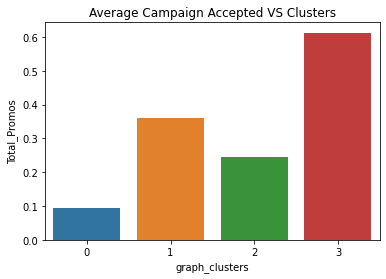

In [53]:
plt.figure()
pl=sns.barplot(x=output.groupby('graph_clusters')['Total_Promos'].mean().index, y=output.groupby('graph_clusters')['Total_Promos'].mean() )
pl.set_title("Average Campaign Accepted VS Clusters")
plt.show()

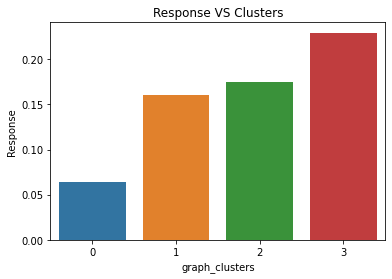

In [54]:
plt.figure()
pl=sns.barplot(x=output.groupby('graph_clusters')['Response'].mean().index, y=output.groupby('graph_clusters')['Response'].mean() )
pl.set_title("Response VS Clusters")
plt.show()

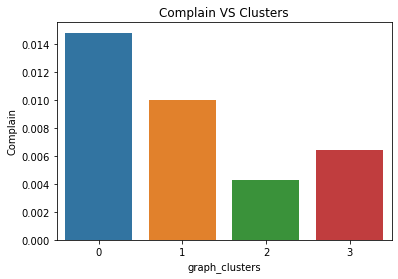

In [55]:
plt.figure()
pl=sns.barplot(x=output.groupby('graph_clusters')['Complain'].mean().index, y=output.groupby('graph_clusters')['Complain'].mean() )
pl.set_title("Complain VS Clusters")
plt.show()

基於消費習慣(各類型產品花費金額)所建立的user-user關聯性,並進一步以此繪製graph  
可以看出雖然消費習慣上response無法得出校明顯的結果  
但在各類型商品的消費習慣上不同組別確實有異(group1消費fish,group2消費gold,group3消費wine...)  
在商品推薦上可以較精準,辦活動時則可以根據活動的商品類型,決定是否進行推薦及花費宣傳資源在特定人身上  
由於不知道各campaign內容,是否為滿額折扣or特定商品折扣,因此難以根據目前擁有的資料分析效果